## Imports

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda


In [2]:
# CONTROL
num_channels = 1
SIZE = (32,32)
model_name = 'models/lane_keeper_small.pt'
onnx_lane_keeper_path = "models/lane_keeper_small.onnx"
max_load = 150_000 #note: it will be ~50% more since training points with pure road gets flipped with inverted labels

## Load Pretrained Net and create Detector 

In [3]:
# # NETWORK ARCHITECTURE
# #very good
# class LaneKeeper(nn.Module):
#     def __init__(self, out_dim=4, channels=1): 
#         super().__init__()
#         ### Convoluational layers
#         self.conv = nn.Sequential( #in = (SIZE)
#             nn.Conv2d(channels, 8, kernel_size=5, stride=1), #out = 30
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2), #out=15
#             nn.BatchNorm2d(8),
#             nn.Conv2d(8, 4, kernel_size=5, stride=1), #out = 12
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=1), #out=11
#             # nn.BatchNorm2d(4),
#             nn.Conv2d(4, 4, kernel_size=6, stride=1), #out = 6
#             nn.ReLU(True),
#         )
#         self.flat = nn.Flatten()
#         ### Linear sections
#         self.lin = nn.Sequential(
#             # First linear layer
#             nn.Linear(in_features=4*4*4, out_features=16),
#             nn.ReLU(True),
#             nn.Linear(in_features=16, out_features=out_dim),
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flat(x)
#         x = self.lin(x)
#         return x

# lane_keeper = LaneKeeper(out_dim=2,channels=num_channels).to(device)

In [4]:
# NETWORK ARCHITECTURE

class LaneKeeper(nn.Module):
    def __init__(self, out_dim=4, channels=1): 
        super().__init__()
        ### Convoluational layers
        prob = 0.2
        self.conv = nn.Sequential( #in = (SIZE)
            nn.Conv2d(channels, 4, kernel_size=5, stride=1), #out = 28
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=14
            nn.BatchNorm2d(4),
            nn.Dropout(p=prob),
            nn.Conv2d(4, 4, kernel_size=5, stride=1), #out = 10
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=5
            nn.Dropout(p=prob),
            nn.Conv2d(4, 32, kernel_size=5, stride=1), #out = 1
            nn.ReLU(True),
        )
        self.flat = nn.Flatten()
        ### Linear sections
        self.lin = nn.Sequential(
            #normalize
            # nn.BatchNorm1d(3*3*4),
            # First linear layer
            nn.Linear(in_features=1*1*32, out_features=32),
            nn.ReLU(True),
            # nn.Tanh(),
            nn.Linear(in_features=32, out_features=out_dim),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

lane_keeper = LaneKeeper(out_dim=2,channels=num_channels).to(device)

In [5]:
# TEST NET INPUTS/OUTPUTS
#show the image with opencv
img = cv.imread('tests/test_img.jpg')
img = cv.resize(img, SIZE)
if num_channels == 1:
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=2)
#convert to tensor
img = torch.from_numpy(img).float()
img = img.permute(2,0,1)
#add dimension
img = img.unsqueeze(0).to(device)
print(img.shape)

lane_keeper.eval()

# Inference
with torch.no_grad():
    output = lane_keeper(img)
    print(f'out shape: {output.shape}')

torch.Size([1, 1, 32, 32])
out shape: torch.Size([1, 2])


## Loading images and Labels

In [6]:
# IMG LOADER AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint
from time import time, sleep


def load_and_augment_img(img, folder='training_imgs'):



    #convert to gray
    img = cv.resize(img, (4*SIZE[1], 4*SIZE[0]))

    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #create random ellipses to simulate light from the sun
    light = np.zeros(img.shape, dtype=np.uint8)
    #add ellipses
    for j in range(2):
        cent = (randint(0, img.shape[0]), randint(0, img.shape[1]))
        axes_length = (randint(10//4, 50//4), randint(50//4, 300//4))
        angle = randint(0, 360)
        light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    #create an image of random white and black pixels
    light = cv.blur(light, (50,50))
    noise = randint(0, 2, size=img.shape, dtype=np.uint8)*255
    light = cv.subtract(light, noise)
    light = np.clip(light, 0, 51)
    light *= 5
    #add light to the image
    img = cv.add(img, light)

    # cv.imshow('light', light)
    # if cv.waitKey(0) == ord('q'):
    #     break

    #blur the image
    img = cv.blur(img, (randint(1, 5), randint(1, 5)))

    # cut the top third of the image, let it 640x320
    img = img[int(img.shape[0]/3):,:] ################################# /3
    # assert img.shape == (320,640), f'img shape cut = {img.shape}'

    #edges
    img = cv.resize(img, (2*SIZE[1], 2*SIZE[0]))

    #edges    
    img = cv.Canny(img, 100, 200)

    #blur
    img = cv.blur(img, (3,3))

    #resize 
    img = cv.resize(img, SIZE)

        #add random tilt
    max_offset = 3
    offset = randint(-max_offset, max_offset)
    img = np.roll(img, offset, axis=0)
    if offset > 0:
        img[:offset, :] = 0 #randint(0,255)
    elif offset < 0:
        img[offset:, :] = 0 # randint(0,255)


    # #reduce contrast
    # const = np.random.uniform(0.1,0.8)
    # # if np.random.uniform() > .5:
    # #     const = const*0.2
    # img = 127*(1-const) + img*const
    # img = img.astype(np.uint8)

    # #add noise 
    # std = 60
    # std = randint(1, std)
    # noisem = randint(0, std, img.shape, dtype=np.uint8)
    # img = cv.subtract(img, noisem)
    # noisep = randint(0, std, img.shape, dtype=np.uint8)
    # img = cv.add(img, noisep)

    # #add random brightness
    # max_brightness = 60
    # brightness = randint(-max_brightness, max_brightness)
    # if brightness > 0:
    #     img = cv.add(img, brightness)
    # elif brightness < 0:
    #     img = cv.subtract(img, -brightness)

    # #blur 
    # img = cv.blur(img, (randint(1,3),randint(1,3)))

    # # invert color
    # if np.random.uniform(0, 1) > 0.6:
    #     img = cv.bitwise_not(img)

    return img


cv.namedWindow('img', cv.WINDOW_NORMAL)
# cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)

for i in range(500):
    img = cv.imread(os.path.join('training_imgs', f'img_{i+1}.png'))
    img = load_and_augment_img(img)
    cv.imshow('img', img)
    key = cv.waitKey(50)
    if key == ord('q') or key == 27:
        break
cv.destroyAllWindows()

In [7]:
# DATASET CLASS
class CsvDataset(Dataset):
    def __init__(self, folder, transform=None, max_load=1000, channels=3):
        self.transform = transform
        self.folder = folder
        self.data = []
        self.channels = channels

        #classification label for road ahead = 1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
        road_images_indexes = []
        tot_lines = 0
        with open(folder+'/classification_labels.csv', 'r') as f:
            lines = f.read().split('\n')
            lines = lines[0:-1] #remove footer
            tot_lines = len(lines)
            for i,line in enumerate(lines):
                if line == '1,0,0,0,1,0,0,0,0,0,0,0,0,0,0':
                    road_images_indexes.append(i)
        print(f'total pure road images: {len(road_images_indexes)}')
        road_imgs_mask = np.zeros(tot_lines, dtype=np.bool)
        road_imgs_mask[road_images_indexes] = True

        with open(folder+'/regression_labels.csv', 'r') as f:
            lines = f.read().split('\n')
            lines = lines[0:-1] #remove footer
            # Get x and y values from each line and append to self.data
            max_load = min(max_load, len(lines))
            # self.all_imgs = torch.zeros((2*max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8) #adding flipped img
            self.all_imgs = torch.zeros((max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8)

            # road images specifically are added again along with their flipped image and label
            road_imgs = torch.zeros((2*len(road_images_indexes), SIZE[1], SIZE[0], channels), dtype=torch.uint8)
            road_labels = []

            cv.namedWindow('img', cv.WINDOW_NORMAL)
            # cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)
            road_idx = 0
            all_img_idx = 0
            for i in tqdm(range(max_load)):

                #label
                line = lines[i]
                sample = line.split(',')
                #keep only info related to the lane, discard distance from stop line 
                sample = [sample[0], sample[1], sample[3]] #e2=lateral error, e3=yaw error point ahead, curvature
                reg_label = np.array([float(s) for s in sample], dtype=np.float32)

                #img 
                img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))

                #check if its in the road images
                if road_imgs_mask[i]:
                    img_r = load_and_augment_img(img.copy())
                    # cv.imshow('imgR', img_r)
                    img_r = img_r[:,:,np.newaxis]

                    img_l = cv.flip(img, 1)
                    img_l = load_and_augment_img(img_l)
                    # cv.imshow('imgL', img_l)
                    img_l = img_l[:,:,np.newaxis]
                    # cv.waitKey(1)

                    road_imgs[2*road_idx] = torch.from_numpy(img_r)
                    road_imgs[2*road_idx+1] = torch.from_numpy(img_l)
                    road_labels.append(reg_label)
                    road_labels.append(-reg_label)
                    road_idx += 1

                else:
                    img = load_and_augment_img(img)
                    if i < 100:
                        cv.imshow('img', img)
                        cv.waitKey(1)
                        if i == 99:
                            cv.destroyAllWindows()
                    #add a dimension to the image
                    img = img[:, :,np.newaxis]
                    self.all_imgs[all_img_idx] = torch.from_numpy(img)
                    self.data.append(reg_label)
                    all_img_idx += 1

            #cut imgs to the right length
            road_imgs = road_imgs[:2*road_idx]
            self.all_imgs = self.all_imgs[:all_img_idx]

            #concatenate all_imgs and road_imgs
            print(f'road images: {road_imgs.shape}')
            print(f'all images: {self.all_imgs.shape}')
            self.all_imgs = torch.cat((self.all_imgs, road_imgs), dim=0)
            print(f'self.data shape: {len(self.data)}')
            print(f'road_labels shape = {len(road_labels)}')
            self.data = np.concatenate((np.array(self.data), np.array(road_labels)), axis=0)

            print(f'\nall imgs: {self.all_imgs.shape}')
            print(f'data: {self.data.shape}')

            #free road_imgs from memory
            del road_imgs
            del road_labels

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # img = read_image(os.path.join(self.folder, f'img_{idx+1}.png'))
        # img = img.float()
        img = self.all_imgs[idx]
        img = img.permute(2, 0, 1).float()
        value = self.data[idx]
        return img, value

In [8]:
#create dataset #takes a long time but then training is faster
train_dataset = CsvDataset('training_imgs', max_load=max_load, channels=num_channels)
#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

total pure road images: 79427


100%|██████████| 142527/142527 [12:25<00:00, 191.27it/s]


road images: torch.Size([158854, 32, 32, 1])
all images: torch.Size([63100, 32, 32, 1])
self.data shape: 63100
road_labels shape = 158854

all imgs: torch.Size([221954, 32, 32, 1])
data: (221954, 3)


In [9]:
#data loader
train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

In [10]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([8192, 1, 32, 32])
torch.Size([8192, 3])


## Training

In [11]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    err_losses2 = []
    err_losses3 = []
    # curv_losses = []

    # Loop over the training batches
    for (input, regr_label) in tqdm(dataloader):
        # Move the input and target data to the selected device
        input, regr_label =input.to(device), regr_label.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)

        #regression
        err2 = output[:, 0]
        err3 = output[:, 1]
        # curv_out = output[:, 2]

        err2_label = regr_label[:, 0]
        err3_label = regr_label[:, 1]
        # curv_label = regr_label[:, 2]

        # Compute the losses
        err_loss2 = 1.0*regr_loss_fn(err2, err2_label)
        err_loss3 = 1.0*regr_loss_fn(err3, err3_label)
        # curv_loss = 1.0*regr_loss_fn(curv_out, curv_label)

        #L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        L1_loss = L1_lambda * L1_norm 
        #L2 regularization
        L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        L2_loss = L2_lambda * L2_norm

        loss = err_loss3 + err_loss2 + L1_loss + L2_loss #+ curv_loss

        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

        #batch loss
        err_losses2.append(err_loss2.detach().cpu().numpy())
        err_losses3.append(err_loss3.detach().cpu().numpy())
        # curv_losses.append(curv_loss.detach().cpu().numpy())

    # Return the average training loss
    err_loss2 = np.mean(err_losses2)
    err_loss3 = np.mean(err_losses3)
    # curv_loss = np.mean(curv_losses)
    return err_loss2, err_loss3

    # VALIDATION FUNCTION
def val_epoch(lane_keeper, val_dataloader, regr_loss_fn, device=device):
    lane_keeper.eval()
    err_losses3 = []
    err_losses2 = []
    # curv_losses = []
    for (input, regr_label) in tqdm(val_dataloader):
        input, regr_label =input.to(device), regr_label.to(device)
        output = lane_keeper(input)

        regr_out = output
        err2 = regr_out[:, 0]
        err3 = regr_out[:, 1]
        # curv_out = regr_out[:, 2]

        err2_label = regr_label[:, 0]
        err3_label = regr_label[:, 1]
        # curv_label = regr_label[:, 2]

        err_loss3 = 1.0*regr_loss_fn(err3, err3_label)
        err_loss2 = 1.0*regr_loss_fn(err2, err2_label)
        # curv_loss = 1.0*regr_loss_fn(curv_out, curv_label)
        loss = err_loss3 + err_loss2

        err_losses2.append(err_loss2.detach().cpu().numpy())
        err_losses3.append(err_loss3.detach().cpu().numpy())
        # curv_losses.append(curv_loss.detach().cpu().numpy())
    return np.mean(err_losses2), np.mean(err_losses3)

In [12]:
# TRAINING 
#parameters
lr = 0.001 #0.005
epochs = 30
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 2e-2 #1e-2
optimizer = torch.optim.Adam(lane_keeper.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn1 = nn.MSELoss() #before epochs/2
regr_loss_fn2 = nn.L1Loss() #after epochs/2 for finetuning

for epoch in range(epochs):
    try:
    # if True:
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2

        err_loss2, err_loss3 = train_epoch(lane_keeper, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_loss2, val_loss3 = val_epoch(lane_keeper, val_dataloader, regr_loss_fn, device)
        clear_output(wait=True)
    except Exception as e:
        print(e)
        torch.cuda.empty_cache()
        continue
    print(f"Epoch  {epoch+1}/{epochs},  loss = {regr_loss_fn} \nyaw_err_loss3: {err_loss3:.4f},   Val: {val_loss3:.4f}")
    print(f"lat_err_loss2: {err_loss2:.4f},   Val: {val_loss2:.4f}")
    # print(f"curv_loss: {curv_loss}")
    torch.save(lane_keeper.state_dict(), model_name)

#Note: sweet spot for training is around 0.016 -> 0.020, also note that training can get stuck, and loss can start improve randomly

Epoch  30/30,  loss = L1Loss() 
yaw_err_loss3: 0.0703,   Val: 0.0684
lat_err_loss2: 0.0277,   Val: 0.0275


In [13]:
# EVALUATE ON TEST SET (UNSEEN DATA)
lane_keeper.load_state_dict(torch.load(model_name))
err_loss2, err_loss3 = val_epoch(lane_keeper, val_dataloader, regr_loss_fn, device)

print(f"lateral_err2_loss: {err_loss2}")
print(f"yaw_err3_loss: {err_loss3}")

100%|██████████| 222/222 [00:00<00:00, 302.20it/s]

lateral_err2_loss: 0.027474619448184967
yaw_err3_loss: 0.06841150671243668


(4, 1, 5, 5)
(4, 4, 5, 5)
(32, 4, 5, 5)


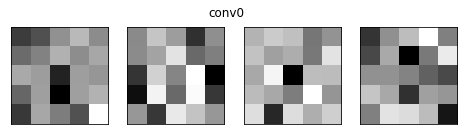

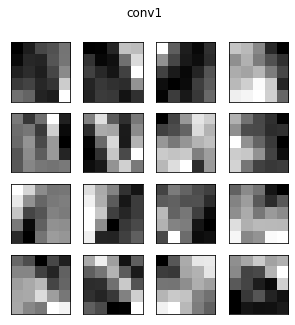

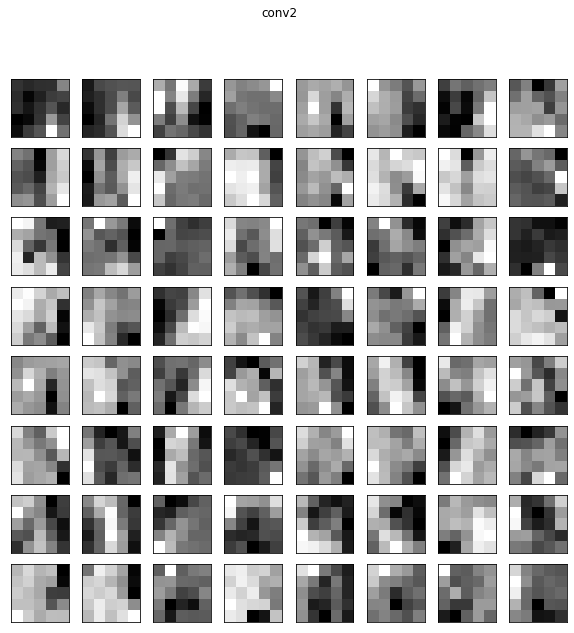

In [14]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(lane_keeper.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))



In [15]:
# CONVERT TO ONNX MODEL FOR OPENCV
lane_keeper.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
lane_keeper.to(device)

# set the model to inference mode
lane_keeper.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, num_channels, SIZE[1], SIZE[0])
torch.onnx.export(lane_keeper, dummy_input, onnx_lane_keeper_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lane_keeper.to(device)

LaneKeeper(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (12): ReLU(inplace=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [16]:
# TEST WITH OPENCV
sample_image = "training_imgs/img_1.png"
images = [cv.imread(f"training_imgs/img_{i+1}.png") for i in range(100)]
 
#The Magic:
lk =  cv.dnn.readNetFromONNX(onnx_lane_keeper_path) 

avg_col = (0,0,0) if num_channels == 3 else 0

for i in tqdm(range(100)):
    image = images[i]
    image = cv.resize(image, SIZE)
    if num_channels == 1:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blob = cv.dnn.blobFromImage(image, 1.0, SIZE, avg_col, swapRB=True, crop=False)
    # print(blob.shape)
    lk.setInput(blob)
    preds = lk.forward()
    # print(f"Predictions: {preds[0][2]}")

print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

100%|██████████| 100/100 [00:00<00:00, 5074.47it/s]

Predictions: [[-0.02668524 -0.00435136]]
Predictions shape: (1, 2)
